In [27]:
import xarray
from distributed import Client, LocalCluster
import numpy as np
import cftime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


cluster = LocalCluster(
    n_workers=1,
    processes=True,
    dashboard_address=":8004",
    threads_per_worker=1,
    memory_limit="50GB"
)
client = Client(cluster)
cluster.scale(10)
client.wait_for_workers(10)
client

/home/jupyterhub/miniconda-persad/envs/lab/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8004 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43835 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:43835/status,
Dashboard: http://127.0.0.1:43835/status,Workers: 10
Total threads: 10,Total memory: 465.66 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38769,Workers: 10
Dashboard: http://127.0.0.1:43835/status,Total threads: 10
Started: Just now,Total memory: 465.66 GiB
Comm: tcp://127.0.0.1:45187,Total threads: 1
Dashboard: http://127.0.0.1:39399/status,Memory: 46.57 GiB
Nanny: tcp://127.0.0.1:43335,


In [3]:
land_mask_path = "/projects/dgs/persad_research/SIMULATION_DATA/DATA/LENS1/CESM1/all/001/day/LANDFRAC/b.e11.B1850C5CN.f09_g16.005.cam.h0.LANDFRAC.200001-209912.nc"
land_mask = xarray.open_dataset(land_mask_path)["LANDFRAC"].mean(dim="time")

all_aodvis = xarray.open_zarr("/projects/dgs/persad_research/SIMULATION_DATA/ZARR/LENS1/SIM_VARIABLES/all_month_AODVIS.zarr")["AODVIS"].where(land_mask > 0).resample(time="YE").mean()
xaer_aodvis = xarray.open_zarr("/projects/dgs/persad_research/SIMULATION_DATA/ZARR/LENS1/SIM_VARIABLES/xaer_month_AODVIS.zarr")["AODVIS"].where(land_mask > 0).resample(time="YE").mean()
xghg_aodvis = xarray.open_zarr("/projects/dgs/persad_research/SIMULATION_DATA/ZARR/LENS1/SIM_VARIABLES/xghg_month_AODVIS.zarr")["AODVIS"].where(land_mask > 0).resample(time="YE").mean()

In [8]:
all_aodvis_ts = all_aodvis.weighted(np.cos(np.deg2rad(all_aodvis.lat))).mean(dim=["lat", "lon"]).compute()
xaer_aodvis_ts = xaer_aodvis.weighted(np.cos(np.deg2rad(xaer_aodvis.lat))).mean(dim=["lat", "lon"]).compute()
xghg_aodvis_ts = xghg_aodvis.weighted(np.cos(np.deg2rad(xghg_aodvis.lat))).mean(dim=["lat", "lon"]).compute()

all_aodvis_ts = all_aodvis_ts.assign_coords(dict(time=[ts.year for ts in all_aodvis_ts.time.values]))
xaer_aodvis_ts = xaer_aodvis_ts.assign_coords(dict(time=[ts.year for ts in xaer_aodvis_ts.time.values]))
xghg_aodvis_ts = xghg_aodvis_ts.assign_coords(dict(time=[ts.year for ts in xghg_aodvis_ts.time.values]))

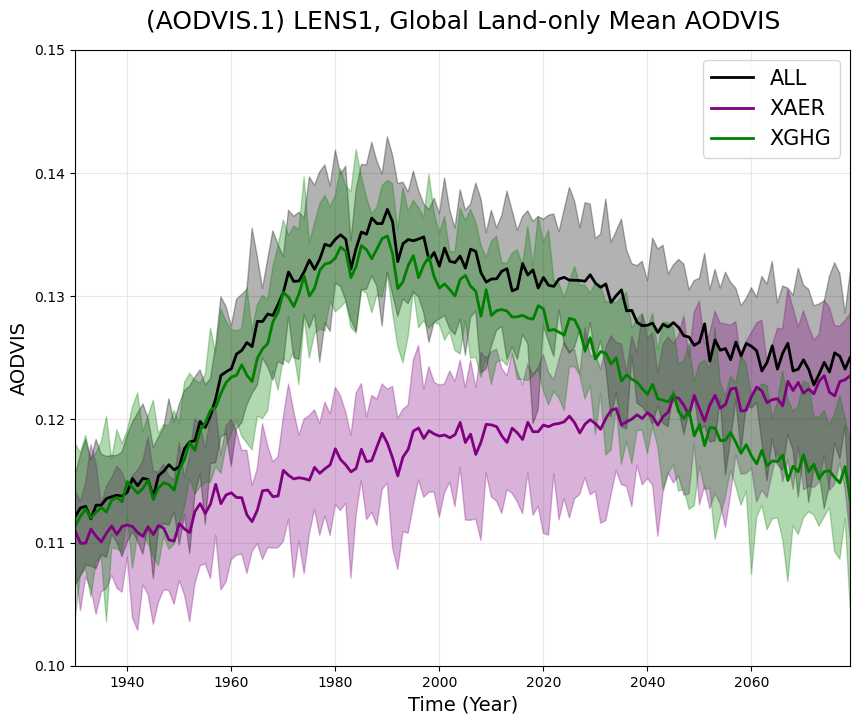

In [23]:
f_background_color = "#ffffff"
ax_background_color = "#ffffff"
grid_line_color = "#e8e8e8"
grid_line_lw = 0.8
all_color = "Black"
xaer_color = "Purple"
xghg_color = "Green"

f, ax1 = plt.subplots(1, 1, figsize=(10, 8), facecolor='w')

f.patch.set_facecolor(f_background_color)
ax1.set_facecolor(ax_background_color)

for i in np.arange(1940, 2080, 20):
    ax1.axvline(i, color=grid_line_color, linewidth=grid_line_lw, zorder=-1)
for i in np.arange(0.1, 0.15, 0.01):
    ax1.axhline(i, color=grid_line_color, linewidth=grid_line_lw, zorder=-1)


lw = 2
all_aodvis_ts.mean(dim=["member"]).plot(ax=ax1, linewidth=lw, color=all_color, label="ALL")
xaer_aodvis_ts.mean(dim=["member"]).plot(ax=ax1, linewidth=lw, color=xaer_color, label="XAER")
xghg_aodvis_ts.mean(dim=["member"]).plot(ax=ax1, linewidth=lw, color=xghg_color, label="XGHG")

a = 0.3
ax1.fill_between(all_aodvis_ts.time.values, all_aodvis_ts.min(dim="member"), all_aodvis_ts.max("member"), alpha=a, color=all_color)
ax1.fill_between(xaer_aodvis_ts.time.values, xaer_aodvis_ts.min(dim="member"), xaer_aodvis_ts.max("member"), alpha=a, color=xaer_color)
ax1.fill_between(xghg_aodvis_ts.time.values, xghg_aodvis_ts.min(dim="member"), xghg_aodvis_ts.max("member"), alpha=a, color=xghg_color)

ax1.legend(fontsize=15)
ax1.set_xlim(1930, 2079)
ax1.set_ylim(0.1, 0.15)
ax1.set_title("(AODVIS.1) LENS1, Global Land-only Mean AODVIS", fontsize=18, pad=15)
ax1.set_xlabel("Time (Year)", fontsize=14)
ax1.set_ylabel("AODVIS", fontsize=14)

f.show()

In [29]:
from scipy.stats import ttest_ind


def sig_testing(all_ds, xaer_ds):
    all_array = all_ds.values
    xaer_array = xaer_ds.values

    def welch_t_test(all_pt, xaer_pt, lat, lon):
        t_val, p_val = ttest_ind(all_pt, xaer_pt, equal_var=False)
        return ((lat, lon), p_val)

    results = []
    for lati, lat in enumerate(all_ds.lat.values):
        for loni, lon in enumerate(all_ds.lon.values):
            all_pt = all_array[0:all_ds["member"].size, 0:all_ds["time"].size, lati, loni].flatten()
            xaer_pt = xaer_array[0:xaer_ds["member"].size, 0:xaer_ds["time"].size, lati, loni].flatten()
            t_value, p_value = ttest_ind(all_pt, xaer_pt, equal_var=False)
            results.append(((lat, lon), p_value))

    sig_results = (all_ds.mean(dim="member").mean(dim="time").load() * 0).rename("p-value")
    for (lat, lon), p_value in results:
        sig_results.loc[dict(lat=lat, lon=lon)] = p_value
    return sig_results

fut_start, fut_end = 2020, 2049
past_start, past_end = 1961, 1990

aodvis_all_fut = all_aodvis.assign_coords(dict(time=[ts.year for ts in all_aodvis.time.values])).where(land_mask > 0).sel(time=slice(fut_start, fut_end)).compute()
aodvis_xaer_fut = xaer_aodvis.assign_coords(dict(time=[ts.year for ts in xaer_aodvis.time.values])).where(land_mask > 0).sel(time=slice(fut_start, fut_end)).compute()
aodvis_all_past = all_aodvis.assign_coords(dict(time=[ts.year for ts in all_aodvis.time.values])).where(land_mask > 0).sel(time=slice(past_start, past_end)).compute()
aodvis_xaer_past = xaer_aodvis.assign_coords(dict(time=[ts.year for ts in xaer_aodvis.time.values])).where(land_mask > 0).sel(time=slice(past_start, past_end)).compute()

aodvis_sig_fut = sig_testing(aodvis_all_fut, aodvis_xaer_fut)
aodvis_sig_past = sig_testing(aodvis_all_past, aodvis_xaer_past)

aodvis_all_fut_map = aodvis_all_fut.mean(dim=["member", "time"])
aodvis_xaer_fut_map = aodvis_xaer_fut.mean(dim=["member", "time"])
aodvis_all_past_map = aodvis_all_past.mean(dim=["member", "time"])
aodvis_xaer_past_map = aodvis_xaer_past.mean(dim=["member", "time"])

In [36]:
pop_path = "/projects/dgs/persad_research/SIMULATION_DATA/DATA/WorldPop/unconstrained/global_mosaic/1km/people_per_pixel/ppp_2020_1km_Aggregated.tif"
pop_ds_raw = xarray.open_dataset(pop_path)["band_data"].sel(band=1)

d_lat = aodvis_all_fut.lat.values[1] - aodvis_all_fut.lat.values[0]
lat_groups = np.arange(aodvis_all_fut.lat.values[0] - 0.5*d_lat, aodvis_all_fut.lat.values[-1] + 0.6*d_lat, d_lat)
d_lon = aodvis_all_fut.lon.values[1] - aodvis_all_fut.lon.values[0]
lon_groups = np.arange(aodvis_all_fut.lon.values[0] - 0.5*d_lon, aodvis_all_fut.lon.values[-1] + 0.6*d_lon, d_lon)
pop_ds_raw = pop_ds_raw.assign_coords(x=(pop_ds_raw.x.values % 360)).sortby("x")
pop_ds_resampled = pop_ds_raw.groupby_bins("y", lat_groups, labels=aodvis_all_fut.lat.values).sum().groupby_bins("x", lon_groups, labels=aodvis_all_fut.lon.values).sum()
pop_ds = pop_ds_resampled.rename({"y_bins":"lat", "x_bins":"lon"}).compute()

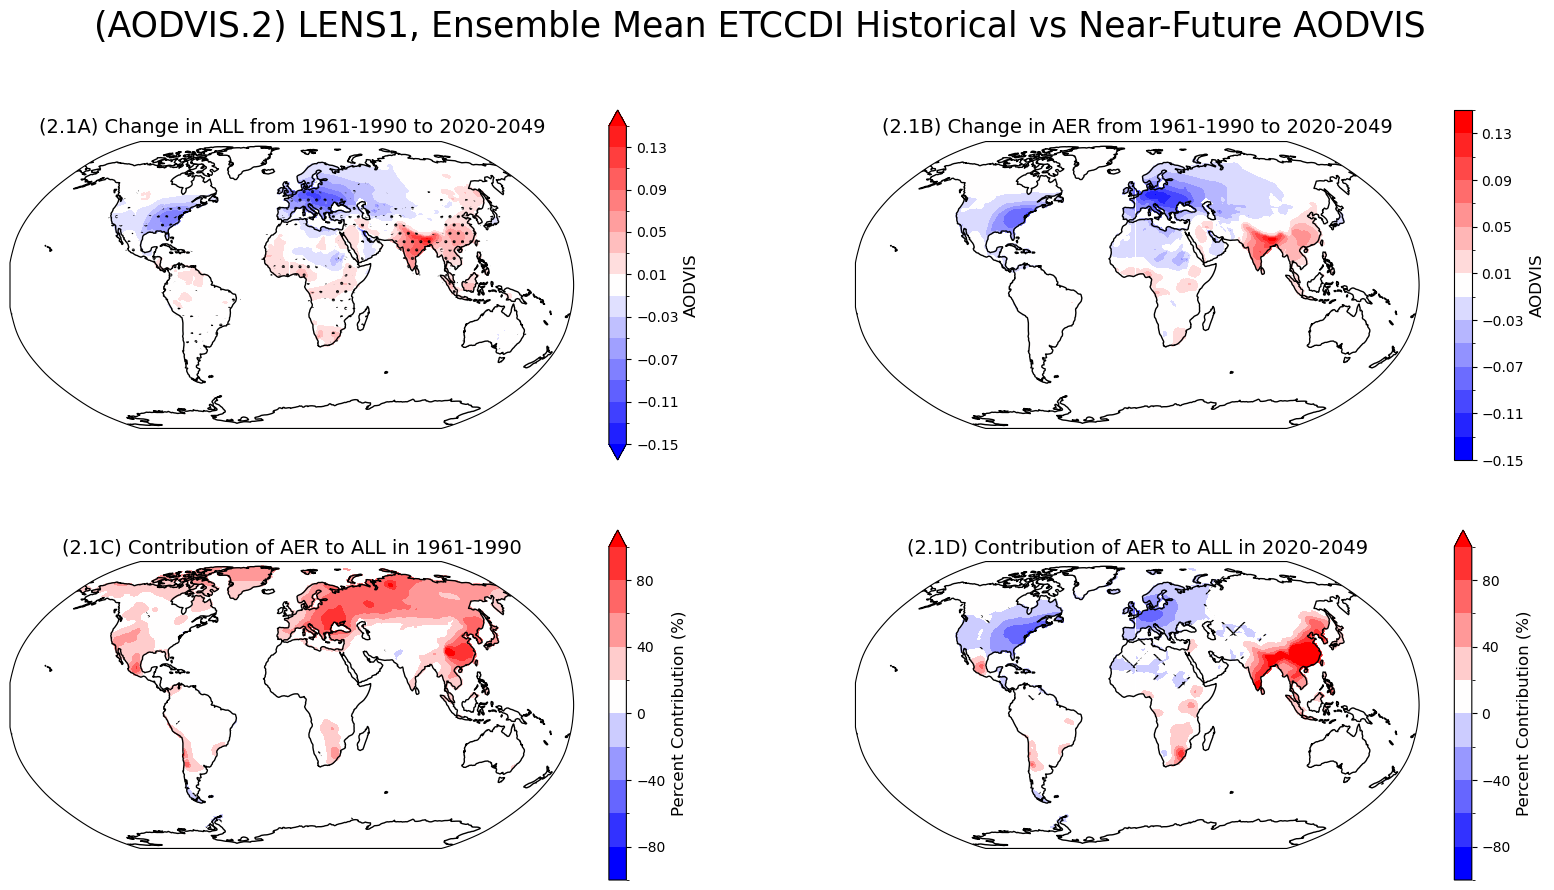

In [40]:

proj = ccrs.Robinson()
transform = ccrs.PlateCarree()
cmap = "bwr"
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 10), facecolor='w', subplot_kw=dict(projection=proj))

levels = np.arange(-0.15, 0.16, 0.02)
cb1 = (aodvis_all_fut_map - aodvis_all_past_map).plot.contourf(ax=ax1, transform=transform, cmap=cmap, vmax=0.15, vmin=-0.15, levels=levels)
cb2 = ((aodvis_all_fut_map - aodvis_xaer_fut_map) - (aodvis_all_past_map - aodvis_xaer_past_map)).plot.contourf(ax=ax2, transform=transform, cmap=cmap, vmax=0.15, vmin=-0.15, levels=levels)

levels = np.arange(-100, 101, 20)
cb3 = (100*((aodvis_all_past_map - aodvis_xaer_past_map) / aodvis_xaer_past_map)).plot.contourf(ax=ax3, transform=transform, cmap=cmap, vmin=-100, vmax=100, levels=levels)
cb4 = (100*((aodvis_all_fut_map - aodvis_xaer_fut_map) / aodvis_xaer_fut_map)).plot.contourf(ax=ax4, transform=transform, cmap=cmap, vmin=-100, vmax=100, levels=levels)

fz = 12
cb1.colorbar.set_label("AODVIS", fontsize=fz)
cb2.colorbar.set_label("AODVIS", fontsize=fz)
cb3.colorbar.set_label("Percent Contribution (%)", fontsize=fz)
cb4.colorbar.set_label("Percent Contribution (%)", fontsize=fz)

X, Y = np.meshgrid(aodvis_sig_fut.lon, aodvis_sig_fut.lat)
ax1.hexbin(X.reshape(-1), Y.reshape(-1), pop_ds.where(pop_ds > 800000).data.reshape(-1), hatch='..', alpha=0, transform=ccrs.PlateCarree())
ax3.hexbin(X.reshape(-1), Y.reshape(-1), aodvis_sig_past.where(aodvis_sig_past > 0.5).data.reshape(-1), hatch='x', alpha=0, transform=ccrs.PlateCarree())
ax4.hexbin(X.reshape(-1), Y.reshape(-1), aodvis_sig_fut.where(aodvis_sig_fut > 0.5).data.reshape(-1), hatch='x', alpha=0, transform=ccrs.PlateCarree())

fz = 14
ax1.set_title(f"(2.1A) Change in ALL from {past_start}-{past_end} to {fut_start}-{fut_end}", fontsize=fz)
ax2.set_title(f"(2.1B) Change in AER from {past_start}-{past_end} to {fut_start}-{fut_end}", fontsize=fz)
ax3.set_title(f"(2.1C) Contribution of AER to ALL in {past_start}-{past_end}", fontsize=fz)
ax4.set_title(f"(2.1D) Contribution of AER to ALL in {fut_start}-{fut_end}", fontsize=fz)

ax1.coastlines()
ax2.coastlines()
ax3.coastlines()
ax4.coastlines()

f.suptitle("(AODVIS.2) LENS1, Ensemble Mean ETCCDI Historical vs Near-Future AODVIS", fontsize=25)
f.show()